# Tarea 1 Hidrodinámica Costera

Programar un algoritmo en el cual se modele la evolución de la altura de ola cuando éstas se propagan sobre un perfil de playa con barra como el de la figura. Cada uno debe elegir un modelo de evolución distinto, con su correspondiente modelo de rotura.

Battjes and Janssen, 1978 Thorton and Guza, 1983 Thorton and Guza, 1983, con la modificación de Whitford (1988) (ver Lipmann et al, (1996) Ec. 22) Baldock et al, 1998 Alsina and Baldock, 2007 Janssen and Battjes, 2007 Comparar con datos experimentales (elegir dos de los casos que se adjuntan a continuación RXX, clasificándolos en términos del Numero de Ursell).
Si bien estos están en formato Matlab, de estructura, lo que importa son solo las variables que se encuentran en la estructura RXX.LWF.H .

Entregue un breve informe de no mas de tres paginas, con la descripción del proceso y el análisis de sus resultados. Entregue ademas el código utilizado en el lenguaje de programación que mas le acomode.

Comentarios:

La mejor forma de hacer esto es usando un esquema de diferencias finitas, comenzando desde la condición de aguas afuera.

No incluya rotura ! (para esta primera tarea).

Les adjunto el articulo de Catalan y Haller (2008), en que se describe en detalle el experimento.

Pueden adjuntar el código en Matlab o Python. (casi que prefiero python, como Jupyter Notebook).

# Desarrollo

Se eligió el modelo de Thorton and Guza, 1983, y los datos experimentales R36 y R38 para el análisis y comparación.

R36.mat

--- R36 PROCESADO ---
VECTOR H (Hs): [0.58078547 0.60797564 0.4627788  0.23512025 0.29441098 0.23727395]
VECTOR X (Posiciones): [23.45 45.45 52.7  60.2  70.95 81.95]
R38.mat

--- R38 PROCESADO ---
VECTOR H (Hs): [0.49197273 0.51434843 0.41267055 0.27142393 0.2592283  0.20610897]
VECTOR X (Posiciones): [23.45 45.45 52.7  60.2  70.95 81.95]
<built-in method items of dict object at 0x78b16abc8540>


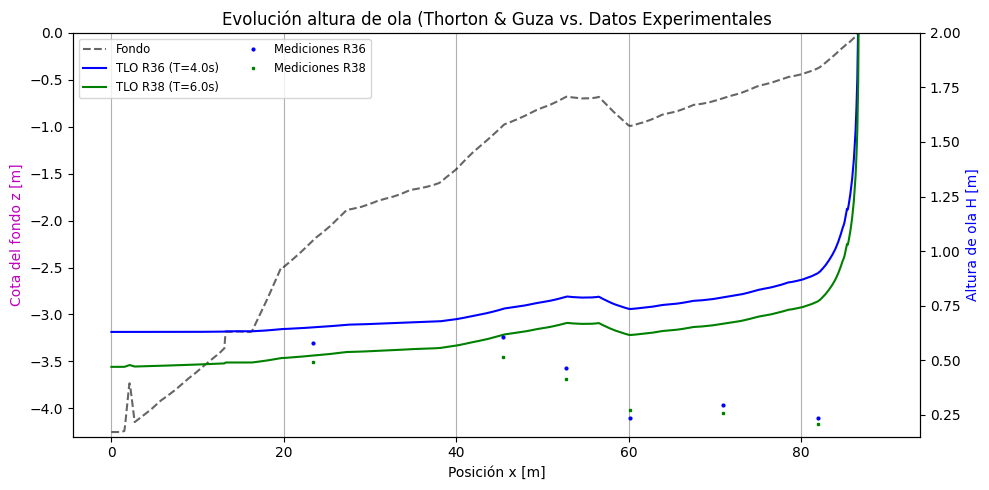

In [ ]:
# -- LIBRERIAS NECESARIAS --

from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton
from scipy.optimize import brentq
from scipy.io import loadmat


# -- PARAMETROS --

g = 9.81
batimetria = "REU2004bathy.txt"
x_model, z_model = np.loadtxt(batimetria, unpack=True, comments='%')
h_model = -z_model
resultados = {}

# Periodo y Ho altura de ola de aguas profundas por experimentos seleccionado
EXP = {
    "R36": {"T": 4.0, "H0": 0.63, "file": "R36.mat", "color": "blue", "marker": "o"},
    "R38": {"T": 6.0, "H0": 0.47, "file": "R38.mat", "color": "green", "marker": "s"},
}

# -- FUNCIONES CLAVE PARA EL DESARROLLO --

# Número de onda k
def k(omega, h):
    if h < 0: return np.nan
    # F(k) = g*k*tanh(kh) - omega^2 = 0
    def F(k): return g * k * np.tanh(k * h) - omega**2
    try:
        return brentq(F, 1e-12, 1000.0)
    except:
        # falla, aguas someras
        return omega / np.sqrt(g * h)

# Velocidad de Grupo Cg
def Cg(omega, k, h):
    if h <= 0: return 1e-6
    C = omega / k
    kh = k * h
    return 0.5 * C * (1.0 + (2.0 * kh) / np.sinh(2.0 * kh))


# ---ALGORITMO EVOLUCION ALTURA DE OLA ---
# Mediante conservación de flujo: H[i+1] = H[i] * sqrt(Cg[i] / Cg[i+1])

def evolucion_de_altura(H0, T, x_model, h_model):
    omega = 2 * np.pi / T
    n_points = len(x_model)
    H_model = np.full(n_points, np.nan)

    # 1. Cg para toda la batimetría
    k_cal = np.array([k(omega, h) for h in h_model])
    cg_cal = np.array([Cg(omega, k, h) for k, h in zip(k_cal, h_model)])

    # 2. (H0) - punto más profundo
    idx = np.argmax(h_model)
    H_model[idx] = H0

    # 3. Diferencias finitas tolerancia 1e-6
    for i in range(idx, n_points - 1):

        Cg_div = max(cg_cal[i+1], 1e-6)
        H_model[i+1] = H_model[i] * np.sqrt(cg_cal[i] / Cg_div)

    for i in range(idx, 0, -1):
        Cg_div = max(cg_cal[i-1], 1e-6)
        H_model[i-1] = H_model[i] * np.sqrt(cg_cal[i] / Cg_div)

    return H_model


    # --- CÁLCULO Y EJECUCIÓN ---

for nombre, p in EXP.items():
    print(p['file'])

    # 1. Calcular evolucion de altura por algoritmo de dif. finitas
    H_model = evolucion_de_altura(p['H0'], p['T'], x_model, h_model)

    # 2. Datos RXX para comparación
    try:
        mat = loadmat(p['file'], struct_as_record=False, squeeze_me=True)
        R   = mat[nombre]
        H_med = np.array(R.LWF.H)
        x_med = np.array(R.xreal)
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo '{mat_file}'.")
    except (KeyError, IndexError, AttributeError):
        print(f"Error: La estructura de '{mat_file}' no coincide con lo esperado.")

    # 3. Almacenamiento de datos
    resultados[nombre] = {
        'H_model': H_model,
        'H_med': H_med,
        'x_med': x_med
    }

    # 4. Confirmación del proceso
    print(f"\n--- {nombre} PROCESADO ---")
    print(f"VECTOR H (Hs): {H_med}")
    print(f"VECTOR X (Posiciones): {x_med}")

# --- GRÁFICA ---

fig, ax1 = plt.subplots(figsize=(10, 5))
H_ylim = (0.1, 3.0)

# Eje Vertical izquierdo, batimetría (profundidad)
ax1.plot(x_model, z_model, 'k--', label='Fondo', alpha=0.6)
ax1.set_xlabel('Posición x [m]')
ax1.set_ylabel('Cota del fondo z [m]', color='m')
ax1.set_ylim(0, np.min(z_model) - 0.05)
ax1.invert_yaxis()
ax1.grid(True, axis='x')

# Eje Vertical derecho, altura de ola
ax2 = ax1.twinx()
ax2.set_ylabel('Altura de ola H [m]', color='b')
ax2.set_ylim(0.15,2)
lines_model = []
lines_med = []
print(resultados.items)

# Grafica por caso analizado
# Algoritmo
for nombre, res in resultados.items():
    p = EXP[nombre]
    line_m, = ax2.plot(x_model, res['H_model'], color=p['color'], linestyle='-',
                       label=f'TLO {nombre} (T={p["T"]:.1f}s)')
    lines_model.append(line_m)
# Mediciones experimentales
for nombre, res in resultados.items():
    p = EXP[nombre]
    if res['x_med'] is not None:
        line_s, = ax2.plot(res['x_med'], res['H_med'], color=p['color'], marker=p['marker'],
                           linestyle='', markersize=2, label=f'Mediciones {nombre}')
        lines_med.append(line_s)

# Leyendas
lines_bat, labels_bat = ax1.get_legend_handles_labels()
ax2.legend(lines_bat + lines_model + lines_med,
           labels_bat + [l.get_label() for l in lines_model] + [l.get_label() for l in lines_med],
           loc='upper left', ncol=2, fontsize='small')


plt.title('Evolución altura de ola (Thorton & Guza vs. Datos Experimentales')
plt.tight_layout()
plt.show()